In [2]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# !conda install keras
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
!pip install transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

import boto3

  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
  Using cached huggingface_hub-0.15.1-py3-none-any.whl (236 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.4/770.4 kB 11.2 MB/s eta 0:00:0000:01
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached safetensors-0.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
#load the dataset
#NOTE THAT SINCE THIS CORPUS IS ONLY IN LOWERCASE, YOU NEED TO FEED THE DATA AS LOWERCASES OR YOU WILL NOT GET *ACCURATE* TRANSLATIONS
client = boto3.client('s3')
df = pd.read_csv(f"s3://sagemaker-eu-west-1-755811905719/output_1686666402/part-00000-238d78a7-0c67-4db3-8634-9e919ca12ce8-c000.csv", delimiter = "\t")


In [15]:
#verify that the dataset has been loaded
print(df.head())
print(df.shape)
print(df['_c0'][0])
print(df['_c1'][0])
print(type(df['_c0'][0]))

                                                 _c0   
0  emekli üyeler kongre'nin şu sıralar çete savaş...  \
1  entellektüellik , klas , asalet veya hikaye il...   
2  hangisi olduğunu tahmin edebildiniz mi ? şirke...   
3  pek uzak yerlere seyahat edemez veya belli bir...   
4                                 heyecanlanmıştım .   

                                                 _c1  
0  retiring members nowadays say that it 's becom...  
1  no sophistication , no class , no dignity , no...  
2                     did you guess it ? companies .  
3  you ca n't travel very far or venture too far ...  
4                                    i was excited .  
(50000, 2)
emekli üyeler kongre'nin şu sıralar çete savaşlarına döndüğünü söylüyorlar .
retiring members nowadays say that it 's become like gang warfare .
<class 'str'>


In [16]:
df.columns = ['turkish', 'english']

# tokenizer = Tokenizer(oov_token="<UNK>")

# # Fit the tokenizer on the texts
# tokenizer.fit_on_texts(df['turkish'].tolist() + df['english'].tolist())

# # Convert the turkish and english columns into sequences
# turkish_sequences = tokenizer.texts_to_sequences(df['turkish'])
# english_sequences = tokenizer.texts_to_sequences(df['english'])

# # Pad the sequences so that they are all the same length
# turkish_padded = pad_sequences(turkish_sequences, padding='post')
# english_padded = pad_sequences(english_sequences, padding='post')

# df['turkish_tokenized'] = turkish_padded.tolist()
# df['english_tokenized'] = english_padded.tolist()

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")  # Initialize the GPT-2 tokenizer
df['english_tokens'] = df['english'].apply(tokenizer.tokenize)  # Tokenize English text
df['turkish_tokens'] = df['turkish'].apply(tokenizer.tokenize)  # Tokenize Turkish text

######################################################################
#TODO: ADD <NUM> TOKEN SO THAT THE MODEL CAN KEEP THE NUMBERS THE SAME
######################################################################

In [17]:
#ensure that the tokenizing is working properly
print(df.head())
 

                                             turkish   
0  emekli üyeler kongre'nin şu sıralar çete savaş...  \
1  entellektüellik , klas , asalet veya hikaye il...   
2  hangisi olduğunu tahmin edebildiniz mi ? şirke...   
3  pek uzak yerlere seyahat edemez veya belli bir...   
4                                 heyecanlanmıştım .   

                                             english   
0  retiring members nowadays say that it 's becom...  \
1  no sophistication , no class , no dignity , no...   
2                     did you guess it ? companies .   
3  you ca n't travel very far or venture too far ...   
4                                    i was excited .   

                                      english_tokens   
0  [ret, iring, Ġmembers, Ġnowadays, Ġsay, Ġthat,...  \
1  [no, Ġsophistication, Ġ,, Ġno, Ġclass, Ġ,, Ġno...   
2       [did, Ġyou, Ġguess, Ġit, Ġ?, Ġcompanies, Ġ.]   
3  [you, Ġca, Ġn, 't, Ġtravel, Ġvery, Ġfar, Ġor, ...   
4                            [i, Ġwas, Ġexcite

In [21]:
# Save the vocabulary to a file
vocab_file = "./gpt2vocab"
tokenizer.save_vocabulary(vocab_file)

('./gpt2vocab/vocab.json', './gpt2vocab/merges.txt')

In [23]:
#create the training, validation and testing datasets
train = df.sample(frac=0.9, random_state=0)
test = df.drop(train.index)
validation = test.sample(frac=0.5, random_state=0)
test = test.drop(validation.index)

#create a pandas dataframe for each of the train, validation and test datasets
train_df = pd.DataFrame({
    'turkish': train['turkish_tokens'].tolist(),
    'english': train['english_tokens'].tolist()
})
validation_df = pd.DataFrame({
    'turkish': validation['turkish_tokens'].tolist(),
    'english': validation['english_tokens'].tolist()
})
test_df = pd.DataFrame({
    'turkish': test['turkish_tokens'].tolist(),
    'english': test['english_tokens'].tolist()
})


(45000, 2)
(2500, 2)
(2500, 2)


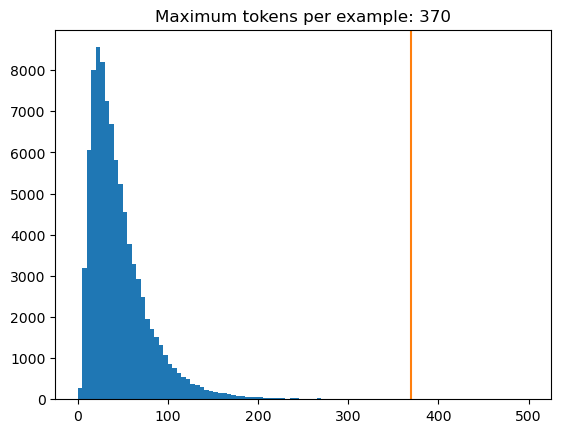

In [43]:
print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

for sample in train_df['turkish'][:]:
    lengths.append(len(sample))
    
plt.hist(lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [16]:
# https://cs.stanford.edu/~zxie/textgen.pdf

NameError: name 'TFTextDataset' is not defined